# CMPSCI 389 HW2a
##### Assigned: Feb 22 2023; Due: Mar 1 2023 @ 11:59 pm EST

#### Abstract
It’s time! We’re making a proper Multi-layer neural network – well, you are at least.

Instead of just doing matrix multiplication we’re also going to include non-linearities. This can be a bit of a headache (not gonna lie to you), but if you think about the computation graph and have the patience to read my dumb comments you’ll be fine – I promise! And yes you still need to use Latex, I’m not backing down on that.

### 1) Primer – what’s different?
So, now that we’re in the realm of multi-layer perceptrons (MLP), things are going to get a little more complicated. In particular we are going to have multiple layers (essentially perceptrons with multiple outputs), which will have weight **matrices**, denoted as ($W_{0}$,$W_{1}$,...,$W_{L}$ for $L$ layers) which will have dimensions of (input size, output size), where the input and output size are the corresponding input and output size of that layer – size is the number of neurons in that layer.

For example we could have a two layer MLP which would then have a $W_{0}$ and $W_{1}$. The data given may have $M$ input features and $C$ output features. In this case we know the sizes of the weight matrices must have be $W_{0} = (M, A)$ and $W_{1} = (A, C)$ where A is some number that we choose. The important part of this is that the first layer must have first dimension equal to the size of the input and the final layer must have final dimension equal to the output size. Everything else is up to us – as long as the match. Hope that landed, but I bet it will by the end of the HW.

![example neural network](L_Layer_Net.png)

\begin{align}
    \text{Figure 1: Example of a L layer neural network – **this is not including a nonlinearity**}
\end{align}

The second major change is that we will include a nonlinearity operation, *σ*, after every layer of our MLP, **besides the final layer**. This *σ* must be a nonlinear function and will be taken on the entire output of each layer.

Because of these two changes we must make use of backpropogation (finding the gradient layer by layer without repeat- ing calculation) and must also remember the output of each layer of the NN (you’ll see why when we do the computation graph – yeah I’m going to make you do one of those)

In the coding part we’re going to refer to the output of a certain layer, *layer*, and its corresponding nonlinearity as *$A_{layer+1}$* . This would make the output of the first ($W_{0}$) layer be represented by $A_{1}$. If you actually read all of this use the *$A_{layer+1}$* notation in the computation graph so I know you’re a ~~tryhard~~ good student.

### 2) Math! and other stuff that will help you (30 points)
Do the math:

1. For the following nonlinearity, calculate the derivative of it w.r.t (with respect to) its input (this is kind of tricky, but if you get stuck the answers in lecture (you didn’t hear it from me). Give it a try first though, pretty please):

\begin{align}
    σ(X) = \frac{1}{1+e^{X}}
\end{align}

\begin{align}
    \frac{∂σ}{∂X}= (1 - \sigma (X) ) \sigma (X)
\end{align}

2. Imagining that we’re using this nonlinearity after a single layer of neural network – calculate the derivative of the output w.r.t the weights.

\begin{align}
    \hat{y} = X \cdot W + b \text{  and  } σ(\hat{y}) = \frac{1}{1+e^{\hat{y}}}
\end{align}

also, recall:

\begin{align}
    \frac{∂A}{∂C} = \frac{∂A}{∂B} * \frac{∂B}{∂C}
\end{align}

solve: 
\begin{equation}
    \frac{∂σ}{∂W}= X^T \cdot (1 - \sigma(\hat{y}))\sigma(\hat{y})
\end{equation}

3. Now something I’m sure you’ll love – draw a computation graph of a 2 layer neural network (2 weight matrices – using dot product as a basic operation) with nonlinearity, σ, between the layers. I.E :

\begin{align}
    \hat{y} = (σ(X\cdot W_{0})+b_{0})\cdot W_{1} + b_{1}
\end{align}

4. Now time to use the computation graph! Use it to solve the following:

\begin{align}
    \frac{∂\hat{y}}{∂b_{0}} = SUM ( (1 - (σ(X\cdot W_{0})+b_{0}))(σ(X\cdot W_{0})+b_{0}) \cdot W_1^T )
\end{align}

\begin{align}
    \frac{∂\hat{y}}{∂W_{0}} = X^T \cdot ((1 - (σ(X\cdot W_{0})+b_{0}))(σ(X\cdot W_{0})+b_{0}) \cdot W_1^T)
\end{align}

### 3) CODING! (60 points)
So I’ll level with you – this is gonna be a little bit harder than the last one. But using everything you know you’ll be able to do it cause I believe in you! BTW **you need to pip install a package called tqdm** for this hw

Primarily, we have a somewhat strange (at first at least) choice to use a dictionary to store everything. This will become tremendously useful though when it comes to doing backpropogation so just trust me I guess ¯\\_(ツ)_/¯. You can just run the first block, then beyond that you'll need to fill out each TODO.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm

def load_data(file_path: str, label: str)->Tuple[np.ndarray, np.ndarray]:
    '''
    This function loads and parses text file separated by a ',' character and
    returns a data set as two arrays, an array of features, and an array of labels.
    Parameters
    ----------
    file_path : str
                path to the file containing the data set
    label : str
                A label of whether to grab training or testing data
    Returns
    -------
    features : ndarray
                2D array of shape (n,c) containing features for the data set
    labels : ndarray
                2D array of shape (n,d) containing labels for the data set
    '''
    D = np.genfromtxt(file_path, delimiter=",")
    if label == "train":
        features = D[0:800, :-3]  # all columns but the last three
        labels = D[0:800, -3:]  # the last 3 columns 
    else:
        features = D[801:1000, :-3]  # all columns but the last three
        labels = D[801:1000, -3:]  # the last 3 columns
    
    return features, labels

1. **Initialize the network:** complete the *initialize_network()* method. 

    For this you’ll recieve a list of layer sizes, *layer_sizes*, which will denote the layer sizes with the first being the input size and the last being the output size, this will tell us what sized weight matrices we'll need.

    **Example:** layer_size = [100,1], this will denote a 1-layer network (like a Perceptron), with inputs with 100 features and 1 feature output. Here we'd want a (100 x 1) weight matrix.

    **Example 2:** layer_size = [100, 20, 1], here we'd want a 2-layer network that took the same size input and generated the same size output, but first multiplies to size 20 first. here we would need to weight matrices (one of size: (100,20) and another of size (20,1))  

    For the weight matrices and bias terms initialize using *np.random.randn()* to sample random numbers between [-1, 1] from a normal distribution (or bell curve or gaussian, all the same). Then use the scale value to scale all of them. These need to be stored in the given dictionary such that the first weight matrix is stored as ”W0” and first bias is ”b0”.

In [3]:
def initialize_network(layer_sizes : list, scale : float):
    """
    This function will inialize weights for an arbitrary neural network defined by
    the number of neurons in each layer, given by 'layer_sizes'
    Your weights should be initialized to be numpy arrays composed of random numbers
    taken from a gaussian distribution with mean=0 and std=1, then multiplied by scale
    Parameters
    ----------
    layer_sizes : np.ndarray
        An array of intergers that denote the number of neurons in each layer
        [100, 50, 20] would denote a network with 100 inputs, a hidden layer
        with 50 neurons and output of size 20 -- this would mean W_0 would have dimensions (100,50) for example
    scale : float
        The scale of our initial weights, our weights should mostly be in the range
        [-1,1] * scale
    
    Returns
    ---------
    init_params : dict
        A dictionary that maps labels for parameters to an array of those parameters' 
        initial values
        You MUST have 'W0' map to the first weight matrix, 'W1' to the second, etc. 
        Hint: "W" + str(1) is "W1"
        AND have the first biases similarly be "b0", "b1", etc
    """

    init_params = {}

    # TODO Initialize the parameter dictionary with weight matrices and biases with random values
    # You need to use np.random.randn() to do this -- you can look up the API
    # This will give a number sampled from a normal distribution (a bell curve) 

    for index in range(len(layer_sizes) - 1):
        init_params["W"+str(index)] = np.random.randn(layer_sizes[index], layer_sizes[index+1]) * scale
        init_params["b"+str(index)] = np.random.randn(layer_sizes[index+1]) * scale

    return init_params

In [4]:
exmaple_layers = [100, 50, 20, 5]
example_scale = 1
your_output = initialize_network(exmaple_layers, example_scale)

print("your output type:",type(your_output) )
print("your output length:", len(your_output))
print("You should have a dictionary with 6 terms")

print(your_output['W2'])
print(your_output['W2'].shape)
print("This should be a 20 x 5 numpy matrix with very small values")

your output type: <class 'dict'>
your output length: 6
You should have a dictionary with 6 terms
[[ 0.39345851  1.93272628  0.43702091 -1.760977    1.16472951]
 [ 0.9614373  -1.00890445  1.22197773 -2.19137605 -0.10224454]
 [-1.53777709 -1.83697359  0.86385973  0.15172785 -0.38518199]
 [ 0.59347831 -0.58606976 -0.06622311  0.1810524   1.06442179]
 [-0.22522814  1.16812953  0.0398927  -0.22575375  1.69632743]
 [-0.1103173  -0.1035706  -0.67203828  1.24676756 -0.62615276]
 [ 1.25146549 -0.15657231 -1.0631834   0.86241297 -0.90986379]
 [-0.38854624  0.22613435  0.62870402  0.27775552  0.07194788]
 [ 0.8874812   0.07707606 -1.26739092  0.37903776 -0.84276798]
 [-0.45060188 -1.54811938  0.67677135  0.41159034 -2.06456491]
 [-0.80516942 -1.25635312  0.70486291 -1.55876954 -0.20855445]
 [-0.7223586  -0.84767658 -0.66633997 -0.57051714  1.68849854]
 [-0.22053329 -1.86462412  1.06388495  0.34268251  0.50532693]
 [ 0.31175921  1.15736971 -0.26977577 -0.36799353 -1.08287864]
 [ 0.08286634  0.1529

2. Next you need to complete the forward for the nonlinearity. Complete the *sigma_forward()* method. The forward is just the calculation of the output of the nonlinear function given some input, IN.

In [5]:
def sigmoid_forward(OUT: np.ndarray):
    """
    performs the nonlinear function (sigmoid) on the given input and returns the result
    this is 1/(1 + e^OUT)

    Parameters
    ----------
    OUT: np.ndarray 
        The given input to some layer

    Returns
    ----------
    A: np.ndarray 
        sigma(OUT), this is the output of your sigmoid function given input, OUT,
        'A' and 'OUT' are used because these are the labels we will use in the next step,
        for now you can ignore the naming.
    """

    ######################################

    # TODO Implement the sigmoid function 

    A = 1/(1 + np.exp(-OUT))
    
    ######################################

    return A

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[0.00669285 0.00857749 0.01098694 0.01406363 0.01798621 0.02297737
 0.02931223 0.03732689 0.04742587 0.06008665 0.07585818 0.09534946
 0.11920292 0.1480472  0.18242552 0.22270014 0.26894142 0.3208213
 0.37754067 0.4378235  0.5        0.5621765  0.62245933 0.6791787
 0.73105858 0.77729986 0.81757448 0.8519528  0.88079708 0.90465054
 0.92414182 0.93991335 0.95257413 0.96267311 0.97068777 0.97702263
 0.98201379 0.98593637 0.98901306 0.99142251]


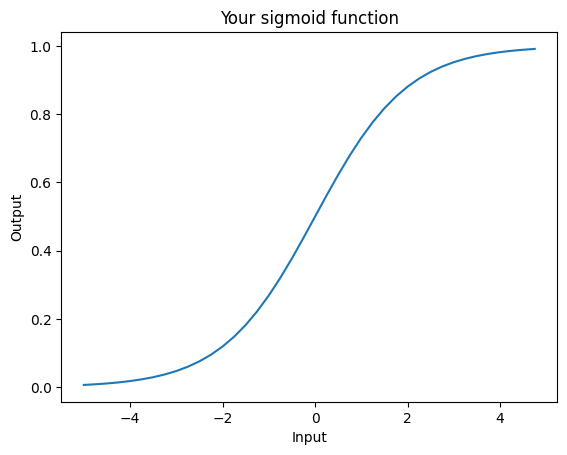

In [12]:
example_inputs = np.arange(-5,5,0.25)
your_output = sigmoid_forward(example_inputs)

plt.plot(example_inputs, your_output)
plt.title("Your sigmoid function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

3. After this you can put it together with your model to make your full *forward()* method, which will do a forward pass through your entire model (each layer, including the nonlinearities). It’s important to note that the final layer is not followed by a nonlinearity. You also must save every intermittent value in the cache (again for use later).

It is important to not only do the forward pass, but also cache the intermittent values so that we (well, *you* ) can do backpropogation next.

In [7]:
def forward(params: dict, X: np.ndarray):
    """
    This function will perform the forward pass of your backprop algorithm
    It will calculate your networks prediction using your parameters and
    will keep a cache of all intermittent values (which you need for backprop)
    ** YOU MUST COMPLETE THE "sigmoid_forward()" method for this part **
    Parameters
    ----------
    params : dict
        A dictionary that maps the labels: 'W0', 'W1', etc to their respective
        weight matrices -- this is the current state of your params
    X : np.ndarray
        A 2D numpy array representing input where each row represents a feature vector
    
    Returns
    ---------
    prediction : np.ndarray
        A 1D numpy array holding the predictions of your network given input X
    cache : dict
        A dictionary that holds all of the intermittent values calculated during your
        forward pass of your network (the 'OUT' and 'A'  of each layer), you must have the
        keys of this dictionary be of the form "AL" and "OUTL" where "AL" representes the input
        to the L-th layer of weights and "OUT(L+1)" is the output after multiplying by weights in Layer L . 
        
        X = OUT0 = A0
        XW0 + b0 = OUT1
        sigmoid(XW0 + b0) = A1
        sigmoid(XW0 + b0)W1 + b1 = OUT2
        ... 

        i.e "OUT0" will be the key for exactly the input X and "A0" will be (as a special case) also X  
        generally "AL" will be sigma("OUTL")
    """
    cache = {}

    cache["A0"] = np.copy(X)

    # TODO -- implement the forward pass of your network

    
    out = np.copy(X)

    cache["A0"] = X
    cache["OUT0"] = X

    for w in range(len(params)//2):

        out = np.dot(out, params["W"+str(w)]) + params["b"+str(w)]

        cache["OUT"+str(w+1)] = out

        if w < (len(params)//2 - 1):
            out = sigmoid_forward(out)
            
        cache["A"+str(w+1)] = out

        
    prediction = out

    return prediction, cache

4. Next we are going to start doing the hard part, derivatives! In this step though all you need to do is complete *sigma_backward()* which will calculate the derivative of sigma with respect to its input (whoa! like the math we did!). This method takes its output as an input – why on earth would it do that?? Check out your math! and if it still doesn’t make sense you should check your math.

In [15]:
def sigmoid_backward(A: np.ndarray):
    """
    calculates the derivative of your sigma function give the output of it
    Parameters
    ----------
    A: np.ndarray 
        sigmoid(OUT), this is the A value (output of the sigma) of 
        some layer. This is all we need to find dsigma / dOUT believe it or not
    Returns
    ----------
    dsigmoid: np.ndarray
        the derivative of sigmoid(OUT) dOUT -- this will use the A value
        it will also be very simple
    """

    ######################################

    # TODO Implement the derivative of sigmoid 

    dsigmoid = (1 - A) * A

    ######################################

    return dsigmoid

yours: [0.     0.1875 0.25   0.1875 0.    ]
correct: [0, 0.1875, 0.25, 0.1875, 0]


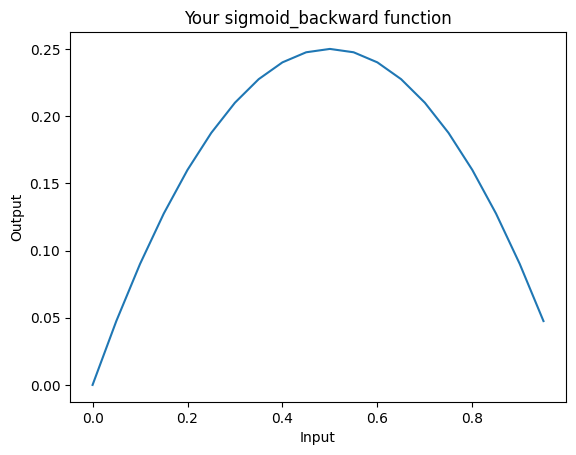

In [17]:
example_A = np.array([1, 0.75, 0.5, 0.25, 0])
your_dsigmoid = sigmoid_backward(example_A)

print("yours:",your_dsigmoid)
print("correct:", [0, 0.1875, 0.25, 0.1875, 0])

example_inputs = np.arange(0,1,0.05)
your_output = sigmoid_backward(example_inputs)

plt.plot(example_inputs, your_output)
plt.title("Your sigmoid_backward function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()


5. Well it’s later, time to use the cache! This next step is the heart of your entire homework so it may take a little bit. You are going to complete the *backprop_and_loss()* method which will take your network, your cache, and the true output and calculate the loss as well as the gradient of loss with respect to every parameter (i.e. each ”WL” and ”bL”) and store those gradients in a cache using the same naming convention. **Note:** this uses MEAN squared error

In [2]:
def backprop_and_loss(params: dict, prediction: np.ndarray, cache: dict, Y : np.ndarray):
    """
    This function will calculate the loss (LSE) of your predictions and the gradient
    of your network for a single iteration. To calculate the gradient you must
    use backpropogation through your network
    ** YOU MUST COMPLETE THE "sigmoid_backward()" method for this part **
    Parameters
    ----------
    params : dict
        A dictionary that maps the labels: 'W0', 'W1', etc to their respective
        weight as well as 'b0', 'b1', etc to the bias
        -- this is the current state of your params
    prediction : np.ndarray
        A 1D numpy array holding the predictions of your network given input X
    cache : dict
        A dictionary that holds all of the intermittent values calculated during your
        forward pass of your network (the 'OUT' and 'A'  of each layer), you must have the
        keys of this dictionary be of the form "AL" and "INL" where "AL" representes the input
        to the L-th layer of weights and "OUT(L+1)" is the output after multiplying by weights in Layer L . 
        
        i.e "OUT0" will be the key for exactly the input X and "A0" will be (as a special case) also X 
        generally "AL" will be sigma("OUTL")
    Y : np.ndarray
        A 1D numpy array of the correct labels of our input X
    Returns
    ---------
    gradient : dict
        A dictionary that maps the labels: 'W0', 'W1', etc to the gradients of 
        the respective parameters (eg 'W0' -> gradient of first weight matrix)
    loss : float
        The MEAN (use np.mean) Squared Error loss given our predictions and true labels 'Y'. 
    
    """

    gradient = {}

    # TODO calculate the gradients of each layer using backprop -- and calculate loss

    num_layers = len(params)//2
    resid = Y - prediction
    dout = (resid * -2)

    

    for w in range(num_layers):

        reverse_index = (num_layers - w) - 1

        dw = np.dot(cache["A" + str(reverse_index)].T, dout) # (13,800) (dot) (800,3) = (13,3)
        db = np.sum(dout)
        dx = np.dot(dout, params["W"+str(reverse_index)].T)  # (1000,1) (dot) (1,9) -> (1000,9)
        dout  = sigmoid_backward(cache["A" + str(reverse_index)]) * dx
        
        gradient["W"+str(reverse_index)] = dw
        gradient["b"+str(reverse_index)] = db


    loss = np.mean(np.square(resid))

    return gradient, loss

NameError: name 'np' is not defined

6. Now it’s time to actually do the learning! You must complete the *gradient_descent()* method which will call all of your other methods to find first the prediction, then the loss and gradient. It will then use them to do gradient descent on the entire parameter dictionary (using the corresponding gradients). You’re free to do this however you see fit (as long as it works!)

In [20]:
def gradient_descent(X : np.ndarray, Y : np.ndarray, initial_params : dict, lr : float, num_iterations : int)->Tuple[List[float], np.ndarray]:
    """
    This function runs gradient descent for a fixed number of iterations on the
    mean squared loss for a linear model parameterized by the weight vector w.
    This function returns a list of the losses for each iteration of gradient
    descent along with the final weight vector.
    Parameters
    ----------
    X : np.ndarray
        A 2D numpy array representing input where each row represents a feature vector
    Y : np.ndarray
        A 1D numpy array where each element represents a label for MSE
    initial_params : dictionary
        A dictionary holding the initialization of all parameters of the model as np.ndarrays
        (e.g. key 'W0' maps to the first weight array of the neural net) 
    lr : float
        The step-size parameter to use with gradient descent.
    num_iterations : int
        The number of iterations of gradient descent to run.
    Returns
    -------
    losses : list
        A list of floats representing the loss from each iteration and the
        loss of the final weight vector
    final_params : dictionary 
        A dictionary holding all of the parameters after training as np.ndarrays
        (this should have the same mapping as initial_params, just with updated arrays) 
    """

    losses = []
    final_params = {}

    for n in tqdm(range(num_iterations)):  #tqdm will create a loading bar for your loop
        
        # TODO Complete this function. It's the whole sh-bang (Gradient Descent)
        losses = []
        params = initial_params

    for n in tqdm(range(num_iterations)):
        pred, cache = forward(params, X)
        grad, loss = backprop_and_loss(params, pred, cache, Y)
        losses.append(loss)
        params = update_params(params, grad, lr)
  
    losses.append(loss)

    final_params = params

    return losses, final_params

def update_params(params: dict, gradient: dict, alpha: float):

    for w in range(len(params)//2):
        params["W"+str(w)] = params["W"+str(w)] - (alpha * gradient["W"+str(w)])
        params["b"+str(w)] = params["b"+str(w)] - (alpha * gradient["b"+str(w)])

    return params

7. Now you can run it! And once you fix the 1000 bugs that you have... you can run it again and hopefully you see something *somewhat* like below – if you do, congrats! You (probably) have it working:

<img style="display: block; margin: auto;"
src="ex_training.png">
<!-- ![alt text](ex_training.png#center) -->


\begin{align}
    \text{Figure 2: Example Learning curve plot with default hyperparameters.}
\end{align}

Run both of these blocks and see if your graph looks similar

In [22]:
def learning_curve(losses: list, names : list):
    """
    This function plots the learning curves for all gradient descent procedures in this homework.
    The plot is saved in the file learning_curve.png. No TODO here
    Parameters
    ----------
    losses : list
        A list of arrays representing the losses for the gradient at each iteration for each run of gradient descent
    names : list
        A list of strings representing the names for each gradient descent method
    Returns
    -------
    nothing
    """
    for loss in losses:
        plt.plot(loss)
    plt.xscale("log")
    plt.ylim(0, 10000)
    plt.xlabel("Iterations")
    plt.ylabel("Squared Loss")
    plt.title("Gradient Descent")
    plt.legend(names)
    plt.savefig("learning_curve.png")
    plt.show()


100%|██████████| 1000/1000 [00:00<00:00, 3438.09it/s]


final training loss values
single layer.........   214.0
two layer............   219.0
many layer...........   221.5


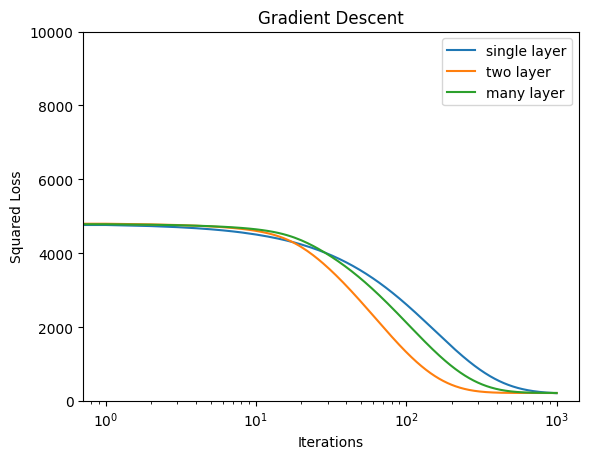

test loss of model 1: 135290.86491626845
test loss of model 2: 141023.7156232359
test loss of model 3: 143078.53164745844


In [23]:
def main():
    Train_X, Train_Y = load_data("StudentsPerformance.csv", "train")  # load the data set

    N = 1000 # N needs to equal 10,000 for your final plot. You can lower it to tune hyperparameters.

    init_params0 = initialize_network([17,3], scale=0.1) # initializes a sigle layer network (perceptron)
    losses0, final_params0 = gradient_descent(Train_X, Train_Y, init_params0, lr=1e-6, num_iterations=N)  

    init_params1 = initialize_network([17, 5, 3], scale=0.1)  # initializes a two layer network
    losses1, final_params1 = gradient_descent(Train_X, Train_Y, init_params1, lr=1e-6, num_iterations=N)  
   
    init_params2 = initialize_network([17, 7, 3, 3], scale=0.1)  # initializes a many layer network
    losses2, final_params2 = gradient_descent(Train_X, Train_Y, init_params2, lr=1e-6, num_iterations=N)   

    all_losses = [losses0, losses1, losses2]
    names = ["single layer", "two layer", "many layer"]
    print("final training loss values")
    for name, losses in zip(names, all_losses):
        print("{0:.<21}{1:>8.1f}".format(name, float(losses[-1])))

    learning_curve(all_losses, names)

    # TESTING 

    Test_X, Test_Y = load_data("StudentsPerformance.csv", "test")

    pred0, _ = forward(final_params0, Test_X)
    test_loss0 = np.sum(np.square(Test_Y  - pred0)) 
    print("test loss of model 1:", test_loss0)

    pred1, _ = forward(final_params1, Test_X)
    test_loss1 = np.sum(np.square(Test_Y  - pred1)) 
    print("test loss of model 2:", test_loss1)

    pred2, _ = forward(final_params2, Test_X)
    test_loss2 = np.sum(np.square(Test_Y  - pred2)) 
    print("test loss of model 3:", test_loss2)

    # TODO choose the hyper parameters for your best model (change them in train_best_model() )
    # You'll have to uncomment the below lines for once you find your best model

    # best_losses, best_params = train_best_model(Train_X, Train_Y) 
    # best_pred, _ = forward(best_params, Test_X)
    # best_loss = np.sum(np.square(Test_Y - best_pred)) 
    # print("test loss of your \"best\" model:", best_loss)


main()

### 4a) That other bit you forgot about until now (10 points)
1. Use *train_best_model()* (you’ll need to find some good hyperparameters) and plot its training alongside the other 3 models (you’ll need to change code in main to plot this) and show it here – Describe your best model and list the values of its hyperparameters here. You should be able to do significantly better than the default, you will be checked for the code you used to find a best model and for the quality of your final loss.

In [1]:
def train_best_model(Train_X, Train_Y):
    """
    This function will train the model with the hyper parameters
    and layers that you have found to be best -- this model must get below 3
    MSE loss on our test data (which is not the test data you are given)
    """

    # TODO CHANGE THESE VALUES -- you must experiment to find good values
    # Maybe you can use a loop to try many!

    BEST_SCALE = 1.0              # You need
    BEST_LAYERS = [17,3]           # to change
    BEST_ALPHA = 1e-7             # these
    BEST_NUM_ITERATIONS = 1000    # !

    best_params = initialize_network(BEST_LAYERS, BEST_SCALE)
    best_losses, best_final_params = gradient_descent(Train_X, Train_Y, best_params, lr=BEST_ALPHA, num_iterations=BEST_NUM_ITERATIONS)

    learning_curve([best_losses],["best"])

    return best_losses, best_final_params

Train_X, Train_Y = load_data("StudentsPerformance.csv", "train")  # load the data set  
train_best_model(Train_X, Train_Y)

NameError: name 'load_data' is not defined

2. Now note the printed test losses (the loss on the test set which isn’t trained on), for the 3 models and your best, show the train loss and test loss. What is the relationship between these, why do you think this is?